In [10]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from IPython.display import FileLink

plt.ion()   # interactive mode

In [11]:
STORAGE_DIR = '/home/tyler/storage/dogbreed2/'
SAMPLE_SUBMISSION = STORAGE_DIR + 'sample_submission.csv'
RESULT_FILE = STORAGE_DIR + 'results/dogbreeds_results.csv'

In [30]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
    ]),
    'test' : transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(STORAGE_DIR, x),data_transforms[x])
        for x in ['train', 'valid', 'test']
}

dataloders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,shuffle=x != 'test', num_workers=4)
        for x in ['train', 'valid', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

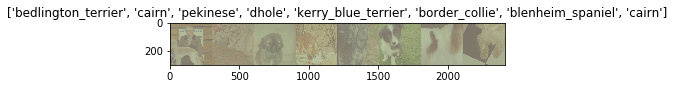

In [31]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.299, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_batch = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs[0].data, 1)
                loss = criterion(outputs[0], labels)
                aux_loss = criterion(outputs[1], labels)
                
                true_loss = loss + aux_loss

                # backward + optimize only if in training phase
                if phase == 'train':
                    true_loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                running_batch +=1

            epoch_loss = running_loss / running_batch
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [37]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['valid']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [38]:
model_conv = torchvision.models.inception_v3(pretrained=True, transform_input=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 120)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/home/tyler/anaconda3/lib/python3.6/site-packages/torchvision-0.1.9-py3.6.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  m.weight.data.copy_(values)


In [39]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 4.0441 Acc: 0.2131


RuntimeError: dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
for param in model_conv.parameters():
    param.requires_grad = True

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

In [ ]:
visualize_model(model_conv)

In [ ]:
path = STORAGE_DIR + 'results/'
torch.save(model_conv.state_dict(), path + 'weights.torch')

In [ ]:
model_conv.load_state_dict(torch.load(path + 'weights.torch'))
model_conv.eval()
predictions = []

for index, test_value in enumerate(dataloders['test']):
    val = test_value[0].cuda()
    
    input = torch.autograd.Variable(val, volatile=True)
    output = model_conv(input)
    predictions.append(func.softmax(output, dim=1).cpu().data.numpy())
    print('\r ' + str(index), end='') 
    
predictions = np.concatenate(predictions)
    
predictions

In [ ]:
imgs = dataloders['test'].dataset.imgs
filenames = []
for file_loc in imgs:
    filenames.append(os.path.splitext(os.path.basename(file_loc[0]))[0])

In [ ]:
sample_submission = pd.read_csv(SAMPLE_SUBMISSION)
columns = sample_submission.columns.values
rows = []

for index, row in enumerate(predictions):
    row = row.tolist()
    row.insert(0, filenames[index])
    rows.append(row)

df = pd.DataFrame(rows, columns=columns)

In [ ]:
df.to_csv(RESULT_FILE, sep=',', index=False)

In [ ]:
%cd ~/notebooks/dogbreed
FileLink("dogbreeds_results.csv")